Let's go.

In [60]:
import pandas as pd

In [61]:
def openData():
    df=pd.read_csv("../data2.csv")
    df.drop_duplicates()
    return df
df=openData()

df=df.dropna(subset=['price'])
df.drop('rooms',axis=1,inplace=True)
df.drop('floor',axis=1,inplace=True)
df['price']/=1e9
df['averageDistrictValue']/=1e6
df['test']/=1e9

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5911 entries, 0 to 5910
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   meter                 5911 non-null   int64  
 1   district              5911 non-null   object 
 2   buildYear             5911 non-null   int64  
 3   price                 5911 non-null   float64
 4   elevator              5911 non-null   int64  
 5   space                 5911 non-null   int64  
 6   parking               5911 non-null   int64  
 7   averageDistrictValue  5911 non-null   float64
 8   test                  5911 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 415.7+ KB


just working a bit with the dataset to understand what's going on. you can pass this.

In [62]:
print(df.describe())

              meter     buildYear        price     elevator        space  \
count   5911.000000   5911.000000  5911.000000  5911.000000  5911.000000   
mean     109.242937   1394.158856    10.749146     0.739807     0.771951   
std     1215.902058    162.933636    12.052792     0.438777     0.419610   
min       20.000000   1370.000000     2.014000     0.000000     0.000000   
25%       60.000000   1385.000000     3.529000     0.000000     1.000000   
50%       80.000000   1393.000000     6.300000     1.000000     1.000000   
75%      114.000000   1400.000000    13.000000     1.000000     1.000000   
max    93500.000000  13902.000000    98.000000     1.000000     1.000000   

           parking  averageDistrictValue          test  
count  5911.000000           5911.000000   5911.000000  
mean      0.861106             97.981969     12.778994  
std       0.345865             48.684225    167.525419  
min       0.000000             34.607752      1.077060  
25%       1.000000            

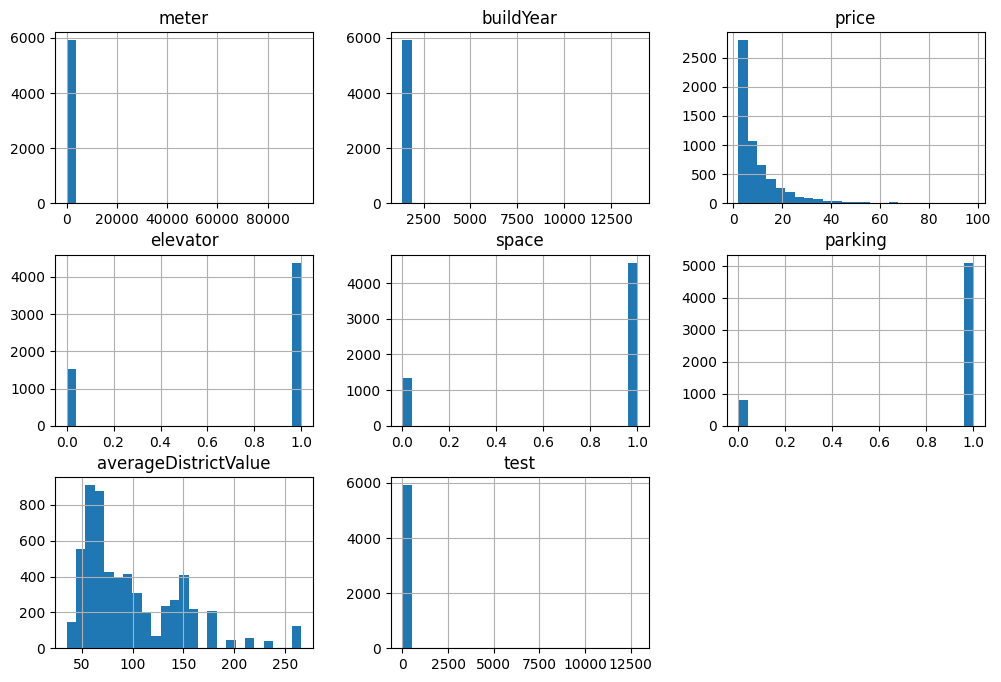

In [63]:
import matplotlib.pyplot as plt
df.hist(bins=25, figsize=(12, 8))
plt.show()

**Deleting the outliers**

In [87]:
import numpy as np
from scipy import stats
outlierHigh = df["price"].quantile(0.98)
outlierLow = df["price"].quantile(0.02)
df.reset_index()
df=df[(df['price'] > 2) & (df['price'] < 100)]
df=df[(df['meter'] > 35) & (df['meter'] < 2000)]
df=df[(df['buildYear'] > 1355) & (df['buildYear'] < 1404)]
df=df[(df['district'].str.contains("[^chitgar]"))] # never learned regex :P
df=df[(df['district'].str.contains("[lake]"))] # never learned regex :P


print(outlierLow,outlierHigh)
df.describe()

2.2 50.0


,meter,buildYear,price,elevator,space,parking,averageDistrictValue,test
count,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000,5818.000000
mean,93.758508,1392.053627,10.830213,0.743383,0.773462,0.861293,98.344563,10.692087
std,48.732093,8.434982,12.114023,0.436804,0.418627,0.345671,48.899879,11.133258
min,36.000000,1370.000000,2.014000,0.000000,0.000000,0.000000,34.607752,1.652185
25%,60.000000,1385.000000,3.550000,0.000000,1.000000,1.000000,60.390190,3.796942
50%,80.000000,1393.000000,6.400000,1.000000,1.000000,1.000000,82.985660,6.391685
75%,115.000000,1400.000000,13.000000,1.000000,1.000000,1.000000,135.086320,13.328554
max,600.000000,1403.000000,98.000000,1.000000,1.000000,1.000000,266.491055,102.599056


**making the test set**

In [65]:
from zlib import crc32
import numpy as np
def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32
def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]


adding an index to data as it's needed.

In [66]:
house_with_id = df.reset_index() # adds an `index` column
train_set, test_set = split_data_with_id_hash(house_with_id, 0.2, "index")

stratified sampling:

count    5867.000000
mean       10.795202
std        12.078131
min         2.014000
25%         3.550000
50%         6.400000
75%        13.000000
max        98.000000
Name: price, dtype: float64


Text(0, 0.5, 'Number of districts')

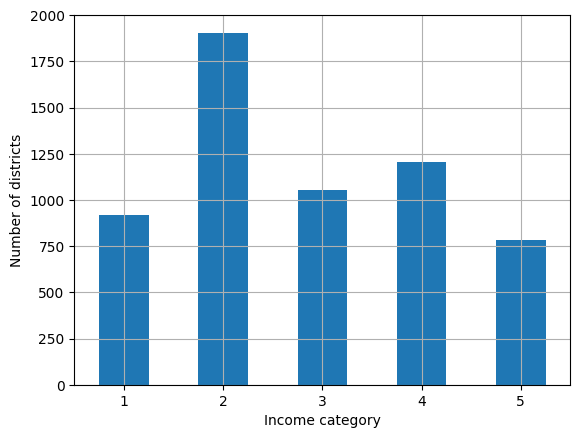

In [67]:
print(df['price'].describe())
df["cat"] = pd.cut(df["price"].astype(float),
bins=[0., 3, 6, 10, 20, np.inf],
labels=[1, 2, 3, 4, 5])
df["cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
# plt.show()

In [68]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
stratSplits = []
for trainIndex, testIndex in splitter.split(df, df["cat"]):
    stratTrainSetN = df.iloc[trainIndex]
    stratTestSetN = df.iloc[testIndex]
    stratSplits.append([stratTrainSetN, stratTestSetN])
    
stratTrainSet, stratTestSet = stratSplits[0]
g=0
with open("errors.txt",'w') as file:
    for i in range(len(df['price'].values)):
        elem=df.iloc[i]
        realPrice=df['price'].values[i]
        error=abs(realPrice-elem['test'])
        if(error>min(elem['test'],realPrice)*2):

            file.write(f"{elem}\n\n")
            g+=1
print(g)

18


In [69]:
for set_ in ( stratTrainSet ,stratTestSet):
    set_.drop("cat", axis=1 , inplace=True)

/tmp/ipykernel_20139/1832761340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("cat", axis=1 , inplace=True)
/tmp/ipykernel_20139/1832761340.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set_.drop("cat", axis=1 , inplace=True)


_**START of the MODEL pre-process**_

In [70]:
house = stratTrainSet.copy()
corr_matrix = house.corr()
print(corr_matrix['price'].sort_values(ascending=False))

/tmp/ipykernel_20139/3448244544.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = house.corr()


price                   1.000000
test                    0.949780
meter                   0.857371
averageDistrictValue    0.796128
space                   0.302643
elevator                0.295214
parking                 0.198660
buildYear               0.174425
Name: price, dtype: float64


_note 1_ : wow it seems that meter is really important!

In [71]:
house = stratTrainSet.drop(['price','district'],axis=1)
labels = stratTrainSet[['price']].copy()

**And finally The PIPELINE**

In [72]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
houseNum=house.select_dtypes(np.number)

num_pipeline = Pipeline([
("impute", SimpleImputer(strategy='most_frequent')),
("normal",StandardScaler())
])
houseNumPrepared=num_pipeline.fit_transform(houseNum)
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
)

preprocessing = ColumnTransformer([],remainder=num_pipeline)
preprocessing.fit(house)
preprocessing

ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                             SimpleImputer(strategy='most_frequent')),
                                            ('normal', StandardScaler())]),
                  transformers=[])

**Train**

**Really, Really Testing for overfitting**

In [73]:
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
forest_reg = make_pipeline(preprocessing,
RandomForestRegressor(random_state=4))
print(sklearn.metrics.get_scorer_names())
forest_mape = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_absolute_percentage_error")
forest_mae = -cross_val_score(forest_reg, house, labels['price'],cv=7,scoring="neg_mean_absolute_error")

['accuracy', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'average_precision', 'balanced_accuracy', 'completeness_score', 'explained_variance', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'fowlkes_mallows_score', 'homogeneity_score', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted', 'matthews_corrcoef', 'max_error', 'mutual_info_score', 'neg_brier_score', 'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_gamma_deviance', 'neg_mean_poisson_deviance', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_median_absolute_error', 'neg_negative_likelihood_ratio', 'neg_root_mean_squared_error', 'normalized_mutual_info_score', 'positive_likelihood_ratio', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'r2', 'rand_score', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc', 'roc_auc_ovo', 'roc_auc_ovo_weight

1.406071961210967 0.0672676040765898
0.13081572955938275 0.0037853631457115864
<class 'pandas.core.series.Series'>
meter                          245
district                   shirazi
buildYear                     1387
price                       57.575
elevator                         1
space                            1
parking                          1
averageDistrictValue    162.968244
test                      39.92722
Name: 1404, dtype: object 33.48300000025999
meter                          260
district                  niloufar
buildYear                     1371
price                         16.0
elevator                         0
space                            0
parking                          1
averageDistrictValue    135.895739
test                     35.332892
Name: 4198, dtype: object 37.24500000025998
meter                          170
district                  dezashib
buildYear                     1380
price                         48.0
elevator                   

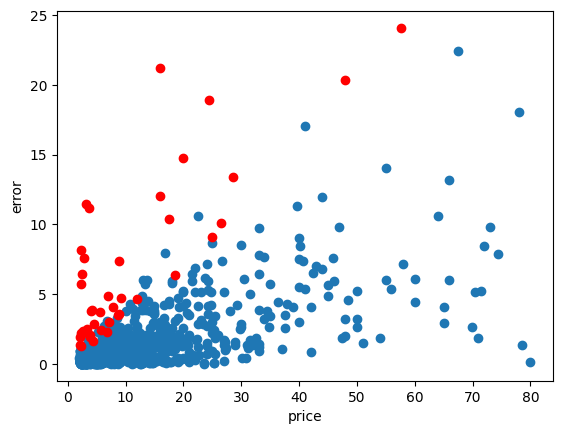

In [79]:

print(forest_mae.mean(),forest_mae.std())
print(forest_mape.mean(),forest_mape.std())
print(type(labels['price']))
forest_reg.fit(house,labels['price'])
housing_predictions = forest_reg.predict(house)

X_test = stratTestSet.drop("price", axis=1)
y_test = stratTestSet[["price"]].copy()

final_predictions = forest_reg.predict(X_test)
a=[[],[]]
b=[[],[]]
dis={}

for i in range(len(y_test)):
    realPrice=y_test.values[i]
    error=abs(realPrice-final_predictions[i])
    if(error>min(final_predictions[i],realPrice)*0.5):
        b[0].append(error)
        b[1].append(realPrice)
        elem=stratTestSet.iloc[i]
        if(error>20):
            print(elem,final_predictions[i])
        if(elem['district'] in dis): 
            dis[elem['district']]+=1
        else: 
            dis[elem['district']]=1
    else:
        a[0].append(error)
        a[1].append(realPrice)
print( {k: v for k, v in sorted(dis.items(), key=lambda item: item[1],reverse=True)})
plt.scatter(a[1],a[0])
print(len(b[1]),len(b[0]))
plt.scatter(b[1],b[0],color='red')
plt.xlabel("price")
plt.ylabel("error")
plt.show()

**Fine tune

In [75]:
from sklearn.model_selection import GridSearchCV
full_pipeline = Pipeline([
("preprocessing", preprocessing),
("random_forest", RandomForestRegressor(random_state=4)),
])
param_grid = [
{'random_forest__max_features': [4],
'random_forest__n_estimators':[100],
'random_forest__max_depth':[20],
'random_forest__min_samples_leaf':[1],
}
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
scoring='neg_mean_absolute_error')
grid_search.fit(house,labels.values.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('impute',
                                                                                     SimpleImputer(strategy='most_frequent')),
                                                                                    ('normal',
                                                                                     StandardScaler())]),
                                                          transformers=[])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=4))]),
             param_grid=[{'random_forest__max_depth': [20],
                          'random_forest__max_features': [4],
                          'random_forest__min_samples_leaf': [1],
                          'random_forest__n_estimators': [100]}],
             scoring='neg_mean_absolute_error')

In [76]:
print(grid_search.best_params_)
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)
cv_res.head()


{'random_forest__max_depth': 20, 'random_forest__max_features': 4, 'random_forest__min_samples_leaf': 1, 'random_forest__n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_depth,param_random_forest__max_features,param_random_forest__min_samples_leaf,param_random_forest__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.078216,0.029189,0.071029,0.006636,20,4,1,100,"{'random_forest__max_depth': 20, 'random_fores...",-1.378313,-1.41892,-1.426972,-1.408068,0.021295,1
